Loading Data In

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns
from IPython.display import display, HTML

# Read the CSV files into dfs
df1 = pd.read_csv('questionnaire.csv')
df2 = pd.read_csv('demographic.csv')
df3 = pd.read_csv('diet.csv')
df4 = pd.read_csv('examination.csv')

# Merge the dfs on the 'seqn' column
df = df1.merge(df2, on='SEQN').merge(df3, on='SEQN').merge(df4, on='SEQN')

# Print the merged df
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df.shape)


(10175, 953)
(10175, 47)
(9813, 168)
(9813, 224)
(9813, 1389)


In [177]:
# List of columns to keep
columns_to_keep = [
    'SEQN', 'RIAGENDR', 'RIDAGEYR', 'DMDEDUC2', 'BPXDI1', 'BPXDI2', 'BPXDI3', 'BPXSY1', 'BPXSY2', 'BPXSY3', 'BMXBMI', 'BMXHT', 'BMXWAIST', 'BMXWT', 'BPQ080',
    'DRQSDIET', 'DRQSPREP', 'MCQ010', 'MCQ160F', 'CDQ001', 'OCQ210', 'DIQ010', 'DIQ160',
    'PAQ650', 'PAQ665', 'DPQ050', 'DPQ040', 'DPQ030', 'DPQ020','ALQ101','ALQ151', 'ALQ120Q', 'ALQ130', 'SMQ020', 'SMQ040', 'DBQ700', 'HSD010', 'SLD010H', 'SMQ050Q', 'SMD055', 'SMD057', 'SMD641', 'SMD650', 'SMD030'
]

# Drop all columns except for the specified ones
df = df[columns_to_keep]

# Drop all rows where RIDAGEYR is less than 18
df = df[df['RIDAGEYR'] >= 18]

df.head()

,SEQN,RIAGENDR,RIDAGEYR,DMDEDUC2,BPXDI1,BPXDI2,BPXDI3,BPXSY1,BPXSY2,BPXSY3,...,SMQ040,DBQ700,HSD010,SLD010H,SMQ050Q,SMD055,SMD057,SMD641,SMD650,SMD030
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,3.0,2.0,2.0,7.0,3.0,66.0,2.0,NaN,NaN,17.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,2.0,3.0,4.0,9.0,NaN,NaN,NaN,1.0,1.0,0.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,3.0,8.0,40.0,26.0,3.0,NaN,NaN,20.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,NaN,2.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,3.0,5.0,5.0,5.0,16.0,40.0,5.0,NaN,NaN,18.0


In [178]:
# Filling Nulls Due to Skip Questions
df.loc[df['ALQ101'] == 2, ['ALQ120Q', 'ALQ130']] = df.loc[df['ALQ101'] == 2, ['ALQ120Q', 'ALQ130']].fillna(0)
df.loc[df['ALQ101'] == 2, ['ALQ151']] = df.loc[df['ALQ101'] == 2, ['ALQ151']].fillna(2)

df.loc[df['SMQ020'] != 1, ['SMQ040']] = df.loc[df['SMQ020'] != 1, ['SMQ040']].fillna(3)

df.loc[df['ALQ120Q'] <= 3, ['ALQ130']] = df.loc[df['ALQ120Q'] <= 3, ['ALQ130']].fillna(0)

In [179]:
# Rename the columns as specified
new_column_names = {
    'SEQN': 'ID',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age',
    'BPXDI1': 'DiasBP1',
    'BPXDI2': 'DiasBP2',
    'BPXDI3': 'DiasBP3',
    'BPXSY1': 'SysBP1',
    'BPXSY2': 'SysBP2',
    'BPXSY3': 'SysBP3',
    'BMXBMI': 'BMI',
    'BMXHT': 'Height',
    'BMXWAIST': 'Waist',
    'BMXWT': 'Weight',
    'BPQ080': 'Cholesterol',
    'DRQSDIET': 'Diet',
    'DRQSPREP': 'SaltFreq',
    'MCQ010': 'Asthma',
    'MCQ160F': 'Stroke',
    'PAQ650': 'VigActivity',
    'PAQ665': 'ModActivity',
    'DPQ050': 'FeelPoorEating',
    'DPQ040': 'FeelTired',
    'DPQ030': 'SleepTroubles',
    'DPQ020': 'FeelDepressed',
    'ALQ151': 'AlcConsumpMoreThan4/5MostDays',
    'ALQ120Q': 'AlcConsumpFreq',
    'ALQ130': 'AlcConsumpAmtPerDrinkDay',
    'SMQ020': '100Cigs',
    'DBQ700': 'OvrDietHealth',
    'HSD010': 'GenHealth',
    'SLD010H': 'SleepDuringWork',
    'SMQ040': 'Smoker',
    'DMDEDUC2': 'EducationLvl',
    'DIQ010' : 'Diabetes',
    'DIQ160' : 'Prediabetic',
    'SMD030' : 'AgeStartedSmokingReg',
    'SMQ050Q': 'TimeQuit',
    'SMD055': 'AgeLastSmokedReg',
    'SMD057': 'WhenSmokedHowMuch',
    'SMD641': 'DaysSmokedInLast30',
    'SMD650': 'AvgCigs/DayInLast30'
}

df.rename(columns=new_column_names, inplace=True)

# Show the first few rows to verify the changes
df.head()

,ID,Gender,Age,EducationLvl,DiasBP1,DiasBP2,DiasBP3,SysBP1,SysBP2,SysBP3,...,Smoker,OvrDietHealth,GenHealth,SleepDuringWork,TimeQuit,AgeLastSmokedReg,WhenSmokedHowMuch,DaysSmokedInLast30,AvgCigs/DayInLast30,AgeStartedSmokingReg
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,3.0,2.0,2.0,7.0,3.0,66.0,2.0,NaN,NaN,17.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,2.0,3.0,4.0,9.0,NaN,NaN,NaN,1.0,1.0,0.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,3.0,8.0,40.0,26.0,3.0,NaN,NaN,20.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,3.0,2.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,3.0,5.0,5.0,5.0,16.0,40.0,5.0,NaN,NaN,18.0


## Feature Descriptions

### Cholesterol
- **Question:** Do you suffer from high cholesterol?

### Diet
- **Question:** Are you on a diet?

### Salt Frequency
- **Question:** How often do you add salt to your food?
  - 1 = Never
  - 2 = Rarely
  - 3 = Occasionally
  - 4 = Very Often

### Asthma
- **Question:** Have you ever been told you have asthma? (Refer to MCQ035 to check if you still have it)

### Stroke
- **Question:** Have you ever had a stroke?

### Vigorous Activity
- **Question:** Do you engage in any vigorous activity?

### Moderate Activity
- **Question:** Do you engage in any moderate activity?

### Over the Last 2 Weeks...
- **FeelPoorEating:** Have you been bothered by poor eating or appetite?
- **FeelTired:** Have you felt tired?
- **SleepTroubles:** Have you struggled to fall asleep, stay asleep, or slept too much?
- **FeelDepressed:** Have you felt depressed?

### Alcohol Consumption
- **AlcConsumpMoreThan4/5MostDays:** Have you ever consumed more than 4/5 drinks on most days?
- **AlcConsumpFreq:** How many days have you consumed alcohol in the past year?
- **AlcConsumpAmtPerDrinkDay:** On days you drank in the last year, on average, how many drinks did you have?

### Smoking
- **SMD030:** Age started smoking regularly (skip if < 100 cigs)
  - 7-64
  - 0 = Never regular
  - 80 = 80+
- **Smoker:** Do you currently smoke?
  - 1 = Every day
  - 2 = Some days
  - 3 = Never
- **SMQ050Q:** How long since you quit? (Skip if smoker = 1/2)
- **SMD055:** Age last smoked regularly (skip if still smokes/< 100 cigs)
- **SMD057:** When did you smoke, how many? (Skip if still smokes/< 100 cigs)
  - 1-90
  - 95+
- **SMD641:** Days smoked in the past 30 days (skip if not a current smoker)
- **SMD650:** Average number of cigarettes per day in the past 30 days (skip if not a current smoker)

### Overall Diet Health
- **Question:** How would you rate the health of your diet?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### General Health
- **Question:** How would you rate your general health condition?
  - 1 = Excellent
  - 2 = Very good
  - 3 = Good
  - 4 = Fair
  - 5 = Poor

### Sleep During Work Days
- **Question:** How much sleep do you get during work days?
  - 2-11 hours
  - 12 = 12+ hours

### Education Level
- **Question:** What is the highest level of school that you have completed?
  - 1 = Less than grade 9
  - 2 = Less than matriculated
  - 3 = High school graduate
  - 4 = Some college degree
  - 5 = College graduate or higher

### Diabetes
- **Question:** Has a doctor ever told you that you have diabetes?
  - 1 = Yes
  - 2 = No
  - 3 = Borderline

### Prediabetic
- **Question:** Has a doctor ever told you that you are prediabetic?


In [180]:
df.head()

,ID,Gender,Age,EducationLvl,DiasBP1,DiasBP2,DiasBP3,SysBP1,SysBP2,SysBP3,...,Smoker,OvrDietHealth,GenHealth,SleepDuringWork,TimeQuit,AgeLastSmokedReg,WhenSmokedHowMuch,DaysSmokedInLast30,AvgCigs/DayInLast30,AgeStartedSmokingReg
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,3.0,2.0,2.0,7.0,3.0,66.0,2.0,NaN,NaN,17.0
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,2.0,3.0,4.0,9.0,NaN,NaN,NaN,1.0,1.0,0.0
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,3.0,3.0,3.0,8.0,40.0,26.0,3.0,NaN,NaN,20.0
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,3.0,2.0,5.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,3.0,5.0,5.0,5.0,16.0,40.0,5.0,NaN,NaN,18.0


## Data Exploration

### Preliminary Feature Engineering

In [181]:
def calculate_average(df, features, new_feature_name):
    # Check and select the relevant columns from the df
    relevant_columns = df[features].replace({0: np.nan})  # Replace zeros with NaN to exclude from mean calculation
    
    # Calculate the mean across the specified columns, ignoring NaN values
    df[new_feature_name] = relevant_columns.mean(axis=1, skipna=True)

In [182]:
diasBP_features = ['DiasBP1', 'DiasBP2', 'DiasBP3']
sysBP_features = ['SysBP1', 'SysBP2', 'SysBP3']

calculate_average(df, diasBP_features, 'AvgDiasBP')
calculate_average(df, sysBP_features, 'AvgSysBP')

In [183]:

conditions = [
    df['AvgSysBP'].isna(),  # Check for NaN values
    df['AvgSysBP'] < 130,
    (df['AvgSysBP'] >= 130) & (df['AvgSysBP'] < 140),
    df['AvgSysBP'] >= 140
]
values = [np.nan, 'Normal', 'Elevated', 'High']

# Use np.select to handle NaNs and assign the appropriate category
df['HypertensionLvl'] = np.select(conditions, values, default=np.nan)

In [184]:
df.head(20)

,ID,Gender,Age,EducationLvl,DiasBP1,DiasBP2,DiasBP3,SysBP1,SysBP2,SysBP3,...,SleepDuringWork,TimeQuit,AgeLastSmokedReg,WhenSmokedHowMuch,DaysSmokedInLast30,AvgCigs/DayInLast30,AgeStartedSmokingReg,AvgDiasBP,AvgSysBP,HypertensionLvl
0,73557,1,69,3.0,72.0,76.0,74.0,122.0,114.0,102.0,...,7.0,3.0,66.0,2.0,NaN,NaN,17.0,74.000000,112.666667,Normal
1,73558,1,54,3.0,62.0,80.0,42.0,156.0,160.0,156.0,...,9.0,NaN,NaN,NaN,1.0,1.0,0.0,61.333333,157.333333,High
2,73559,1,72,4.0,90.0,76.0,80.0,140.0,140.0,146.0,...,8.0,40.0,26.0,3.0,NaN,NaN,20.0,82.000000,142.000000,High
4,73561,2,73,5.0,86.0,88.0,86.0,136.0,134.0,142.0,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,86.666667,137.333333,Elevated
5,73562,1,56,4.0,84.0,82.0,80.0,160.0,158.0,154.0,...,5.0,16.0,40.0,5.0,NaN,NaN,18.0,82.000000,157.333333,High
7,73564,2,61,5.0,80.0,80.0,82.0,118.0,124.0,126.0,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,80.666667,122.666667,Normal
8,73566,2,56,3.0,74.0,72.0,72.0,128.0,124.0,114.0,...,6.0,NaN,NaN,NaN,30.0,1.0,33.0,72.666667,122.000000,Normal
9,73567,1,65,2.0,78.0,78.0,76.0,140.0,142.0,142.0,...,7.0,NaN,NaN,NaN,30.0,25.0,21.0,77.333333,141.333333,High
10,73568,2,26,5.0,60.0,62.0,66.0,106.0,100.0,108.0,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,62.666667,104.666667,Normal
12,73571,1,76,5.0,68.0,NaN,68.0,124.0,NaN,128.0,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,68.000000,126.000000,Normal


In [185]:
# Print the 'Age' values where '100cigs' is NaN
print(df.loc[df['100Cigs'].isna(), 'Age'])

Series([], Name: Age, dtype: int64)


Based on the data description and skips prescribed in the questionaire, should a person not have smoked more than 100 cigarettes in their lifetime, the following features are imputed with nans:
- AgeStartedSmokingReg
- Smoker
- TimeQuit
- AgeLastSmokedReg
- HowMany/DayWhenSmoked
- DaysSmokedInLast30
- Cigs/DayInLast30

We also know that no null values are present due to actual missing information, since all the null values in the 100Cigs feature, were due to children, as demonstrated by the 0 null values in the feature shown above, after children records are removed. The only other null values present in these features would be due to not being smokers, or being smokers

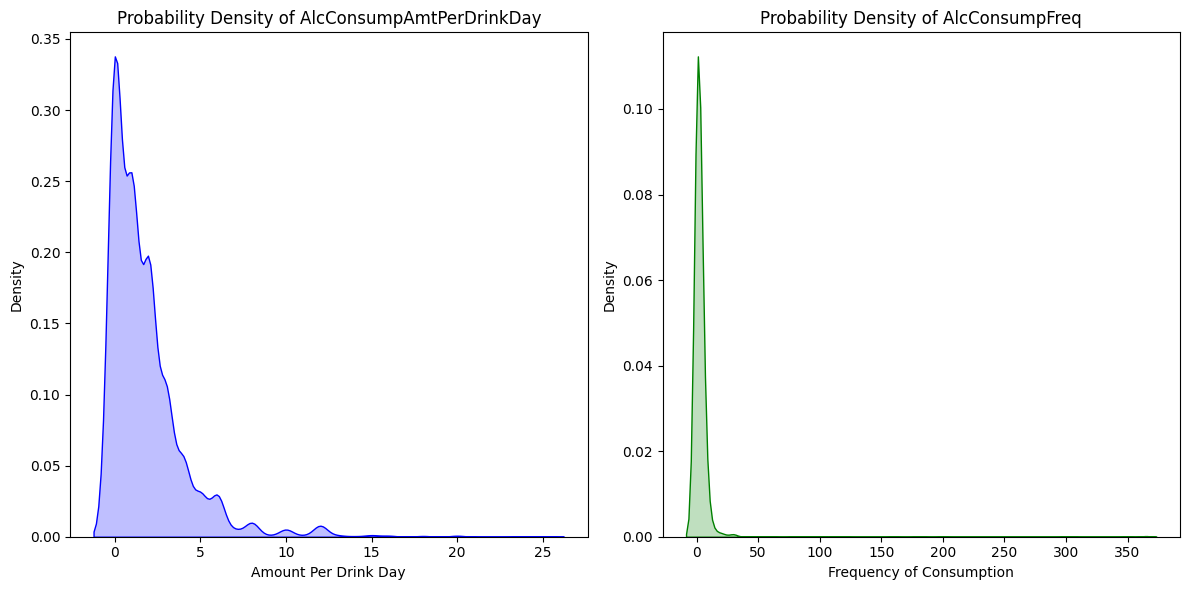

In [186]:
# Filter the DataFrame
filtered_df = df[(df['AlcConsumpAmtPerDrinkDay'] < 77) & (df['AlcConsumpFreq'] < 777)]
# Set up the matplotlib figure
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# KDE plot for AlcConsumpAmtPerDrinkDay
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.kdeplot(filtered_df['AlcConsumpAmtPerDrinkDay'], color='blue', fill=True)
plt.title('Probability Density of AlcConsumpAmtPerDrinkDay')
plt.xlabel('Amount Per Drink Day')
plt.ylabel('Density')

# KDE plot for AlcConsumpFreq
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.kdeplot(filtered_df['AlcConsumpFreq'], color='green', fill=True)
plt.title('Probability Density of AlcConsumpFreq')
plt.xlabel('Frequency of Consumption')
plt.ylabel('Density')

# Show the plot
plt.tight_layout()
plt.show()

In [187]:
def plot_univariate(col):
    if(df[col].nunique()>2):
        plt.figure(figsize=(10,7))
        h = 0.15
        rot=90
    else:
        plt.figure(figsize=(6,6))
        h = 0.5
        rot=0
    plot = sns.countplot(x = df[col], palette='pastel')
    
    for bars in plot.containers:
        for p in bars:
            plot.annotate(format(p.get_height()), (p.get_x() + p.get_width()*0.5, p.get_height()), 
                    ha = 'center', va = 'bottom')
            plot.annotate(f'{p.get_height()*100/df[col].shape[0] : .1f}%', (p.get_x() + p.get_width()*0.5, h*p.get_height()), 
                    ha = 'center', va = 'bottom', rotation=rot)  

In [188]:
def plot_bivariate(col, hue):
    if df[col].nunique() > 5:
        plt.figure(figsize=(20, 10))
        rot = 90
    else:
        plt.figure(figsize=(10, 7))
        rot = 0

    def percentage(ax):
        heights = [[p.get_height() for p in bars] for bars in ax.containers]  # Get the counts of each bar, make arrays when more than one in group
        min_length = min(len(group) for group in heights)  # Find the minimum length of the groups
        for bars in ax.containers:
            for i, p in enumerate(bars):
                if i >= min_length:
                    continue  # Skip if index is out of range for any group
                total = sum(group[i] for group in heights)  # Sum total of each group
                percentage = (100 * p.get_height() / total)  # Calculate % to annotate
                ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() * 0.5, 0.8 * p.get_height()), 
                            ha='center', va='bottom', rotation=0)
                if percentage > 25.0:
                    percentage = f'{percentage:.1f}%'
                    ax.annotate(percentage, (p.get_x() + p.get_width() * 0.5, 0.25 * p.get_height()), 
                                ha='center', va='center', rotation=rot)

    plot = sns.countplot(x=df[col], hue=df[hue], palette='pastel')
    percentage(plot)
    plt.xticks(rotation=rot)
    plt.show()

C:\Users\larry\AppData\Local\Temp\ipykernel_32452\1611043242.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.countplot(x = df[col], palette='pastel')


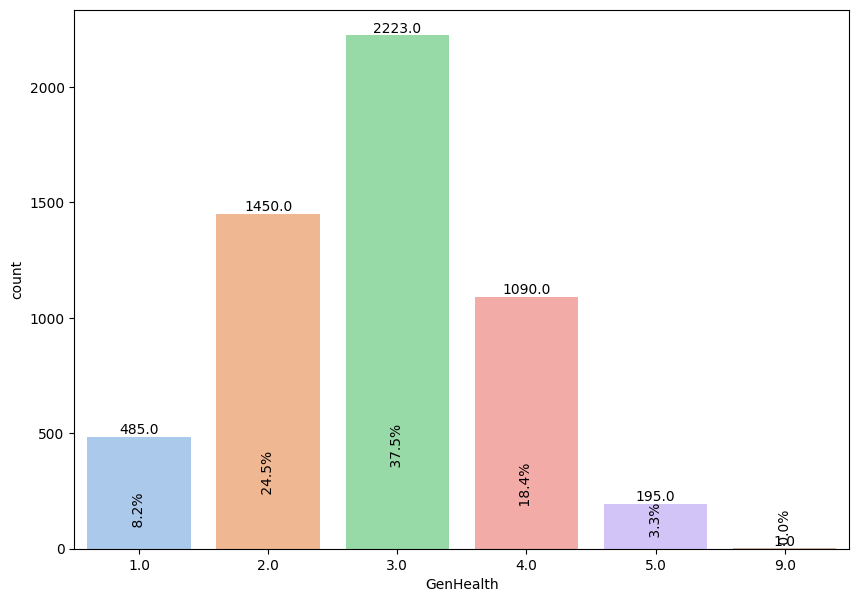

In [189]:
plot_univariate('GenHealth')

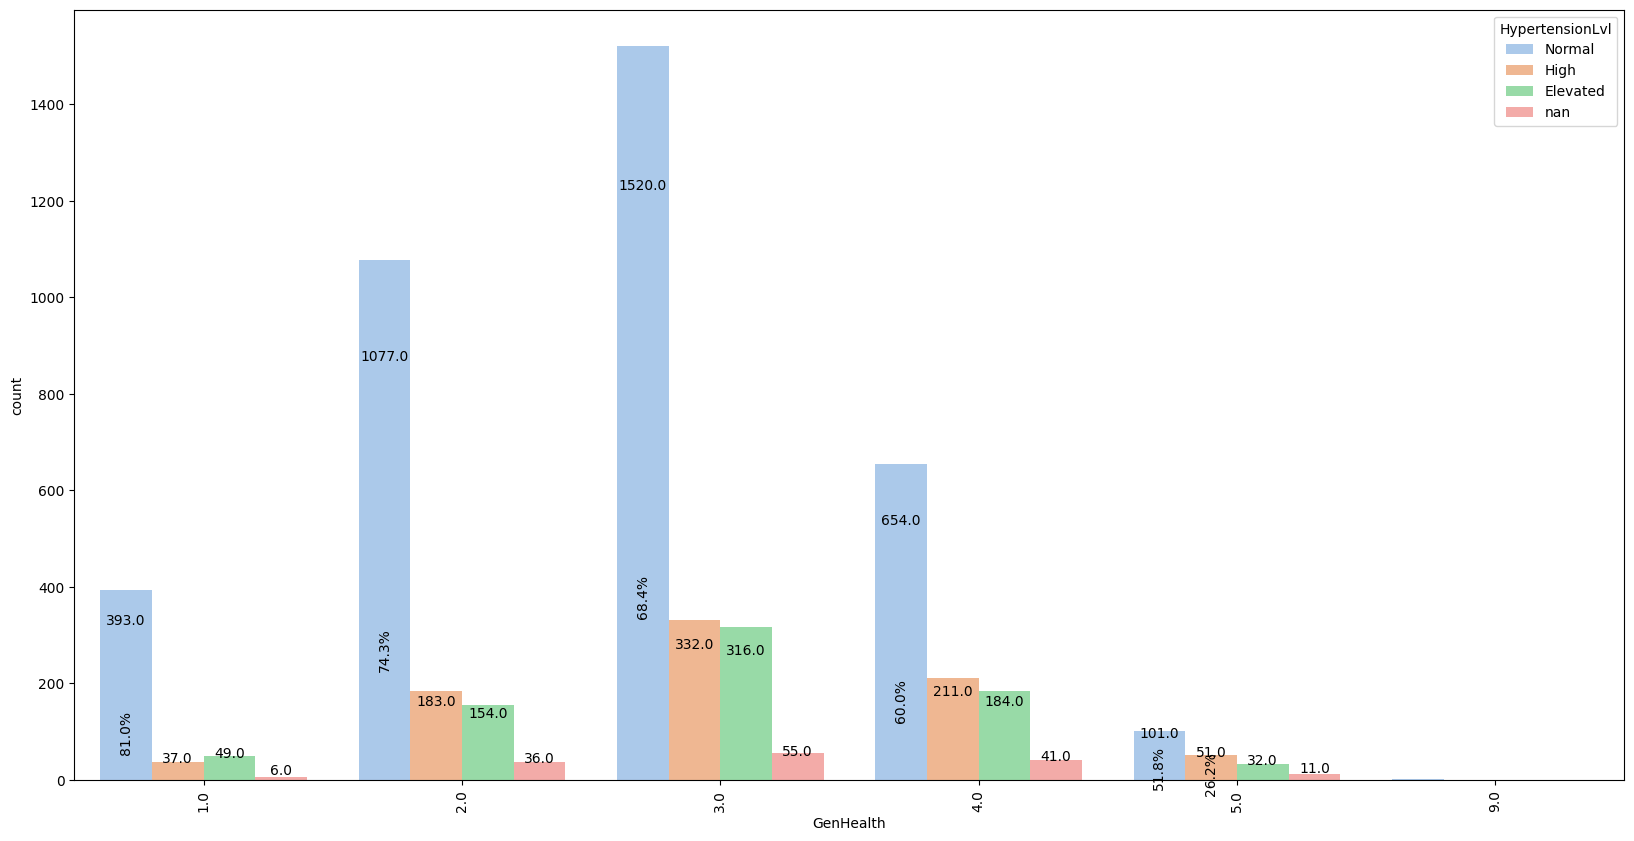

In [190]:
plot_bivariate('GenHealth', 'HypertensionLvl')

In [191]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_distribution(df, columns, threshold=7):
    # Loop through each specified column (feature) in the columns list
    for column in columns:
        # Check if the column exists in the df
        if column in df.columns:
            # Filter the data to include only values smaller than the threshold and skip null values
            filtered_data = df[column].dropna()
            filtered_data = filtered_data[filtered_data < threshold]
            
            # Check if the filtered data is not empty and contains valid numerical values
            if not filtered_data.empty and filtered_data.min() != filtered_data.max():
                # Plot the histogram for the filtered data with narrower bars
                plt.figure(figsize=(8, 5))
                plt.hist(filtered_data, bins=range(int(filtered_data.min()), int(filtered_data.max()) + 2), 
                         alpha=0.7, color='blue', edgecolor='black', width=0.5)  # Adjust 'width' for narrower bars
                
                # Set titles and labels
                plt.title(f'Frequency Distribution of {column}')
                plt.xlabel(column)
                plt.ylabel('Frequency')
                
                # Show the plot
                plt.show()
            else:
                print(f"No valid data to plot for column '{column}'.")
        else:
            print(f"Column '{column}' not found in the df.")


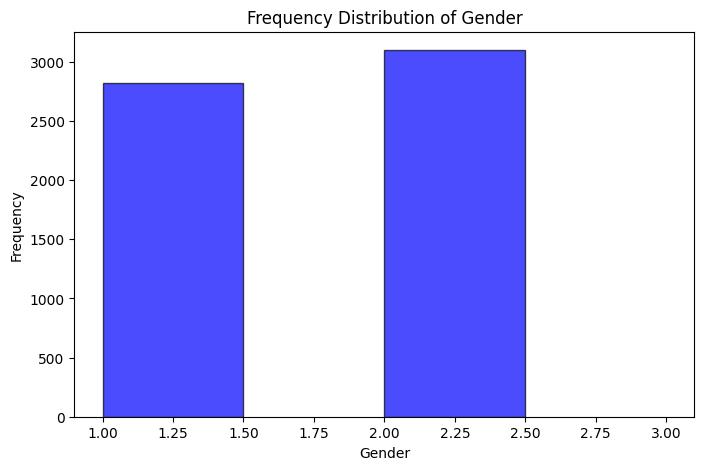

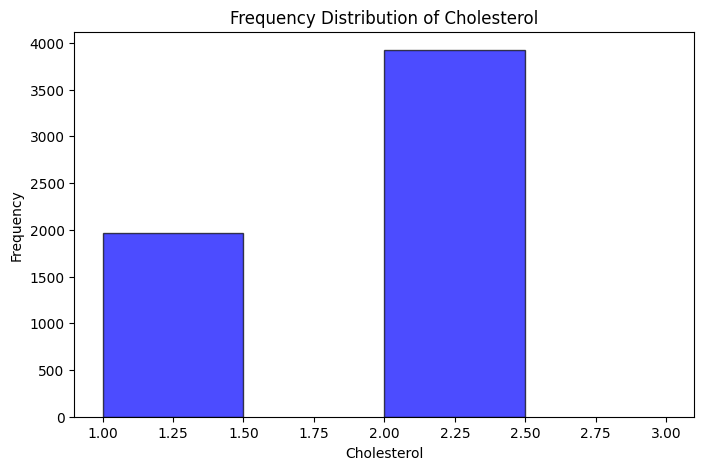

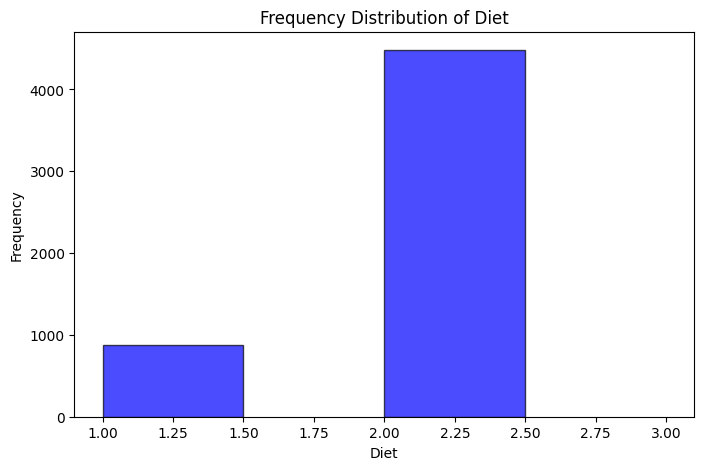

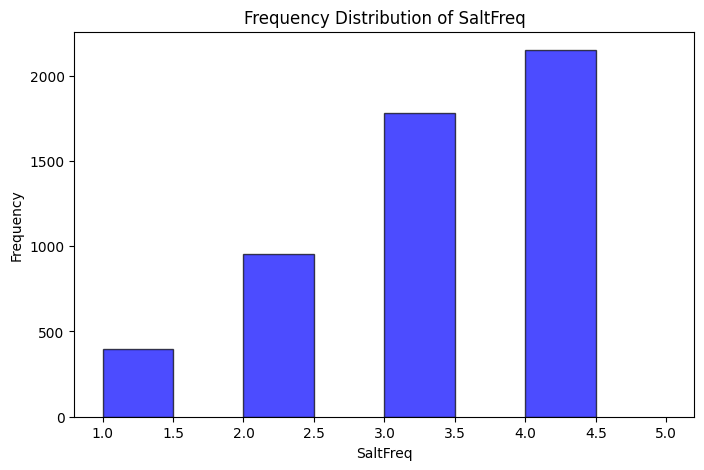

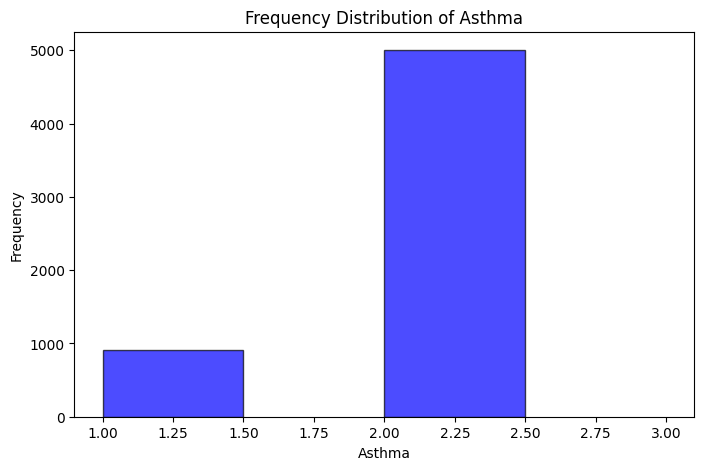

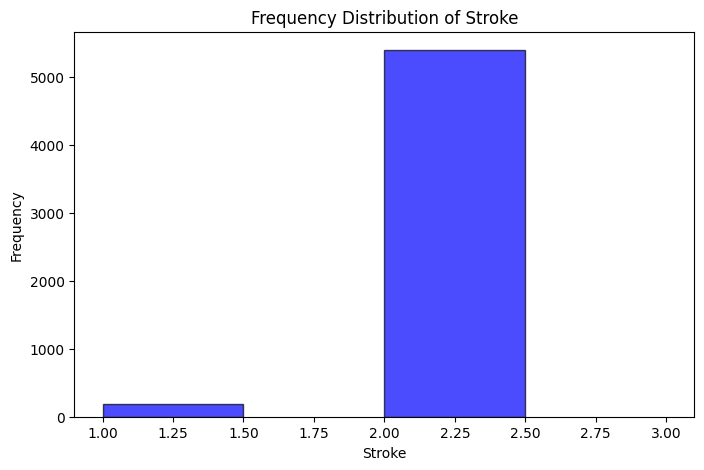

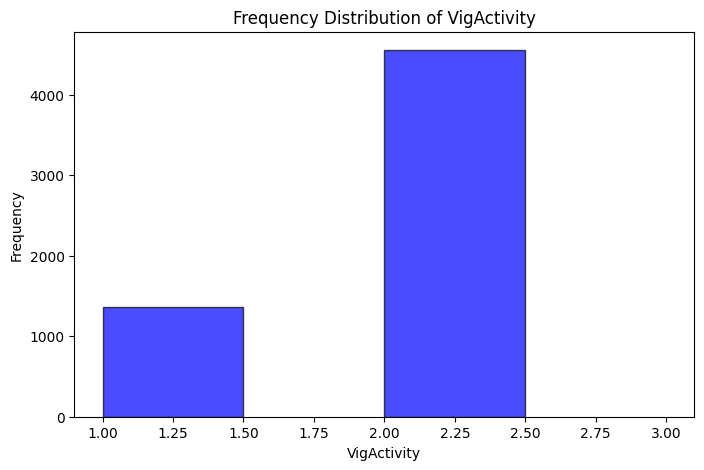

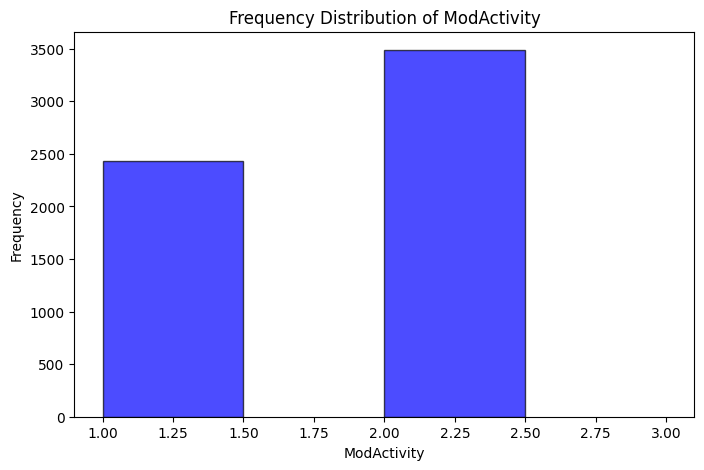

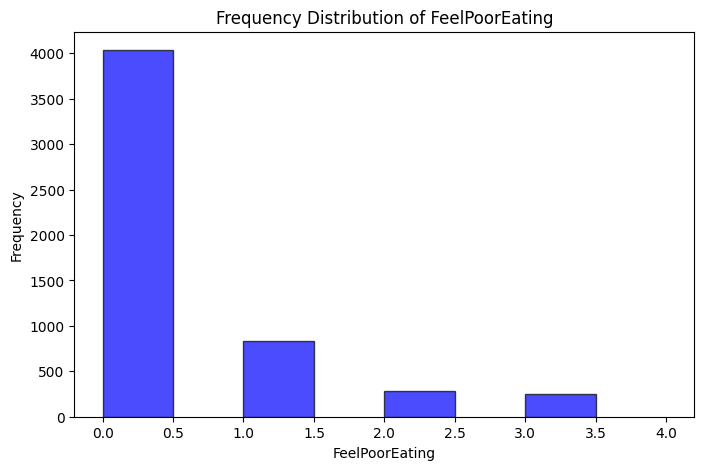

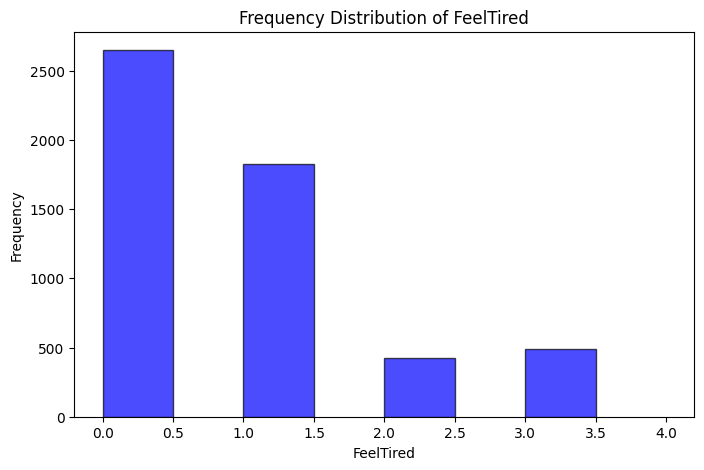

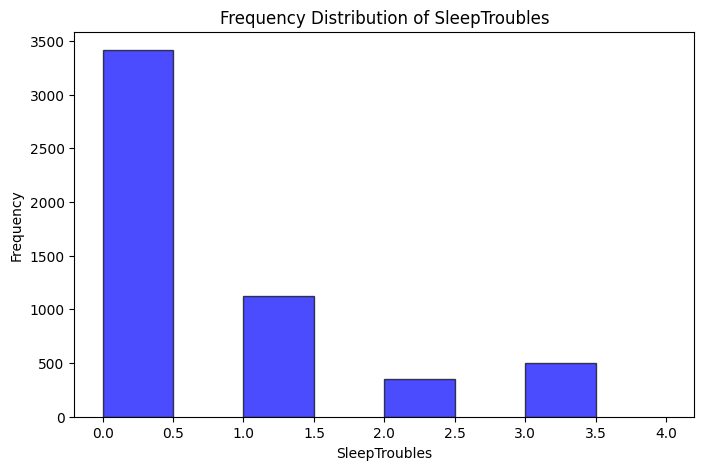

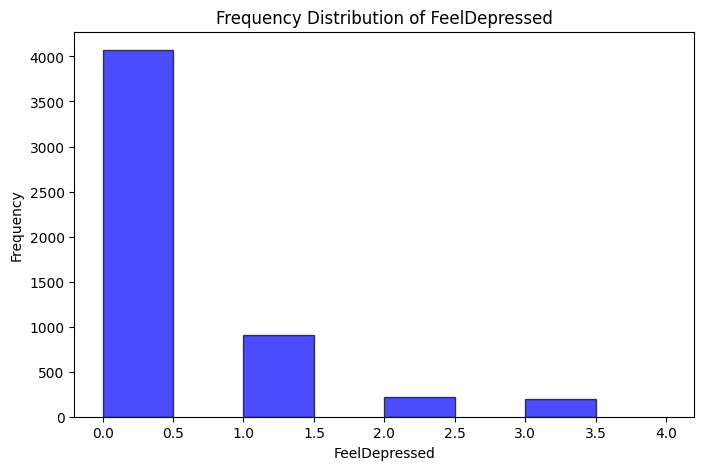

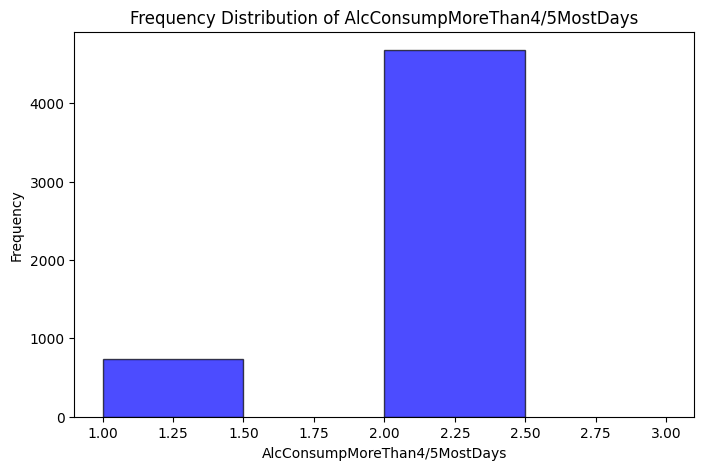

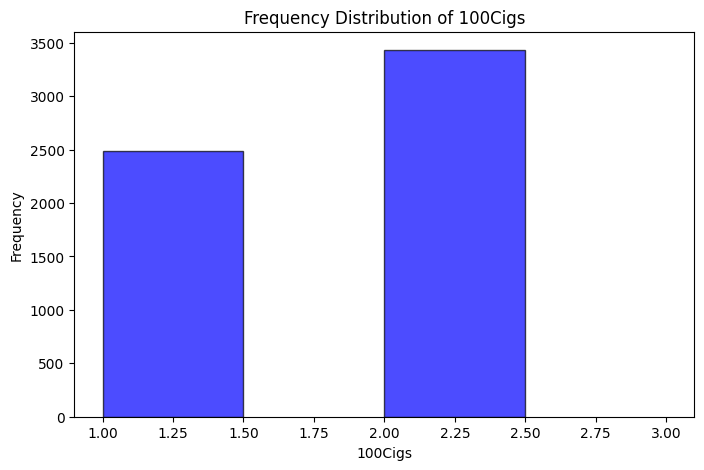

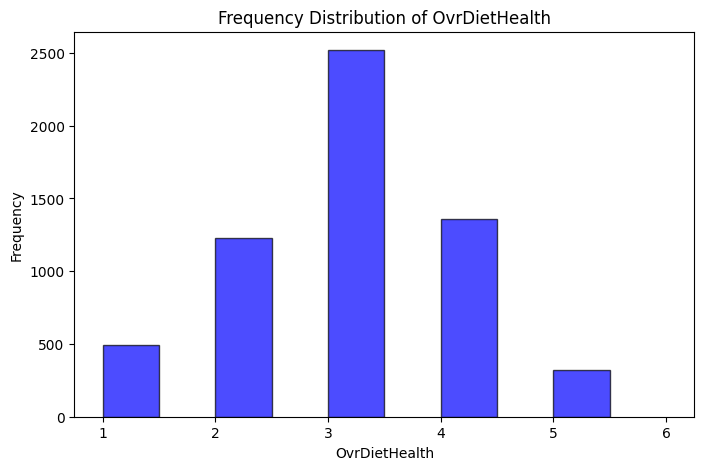

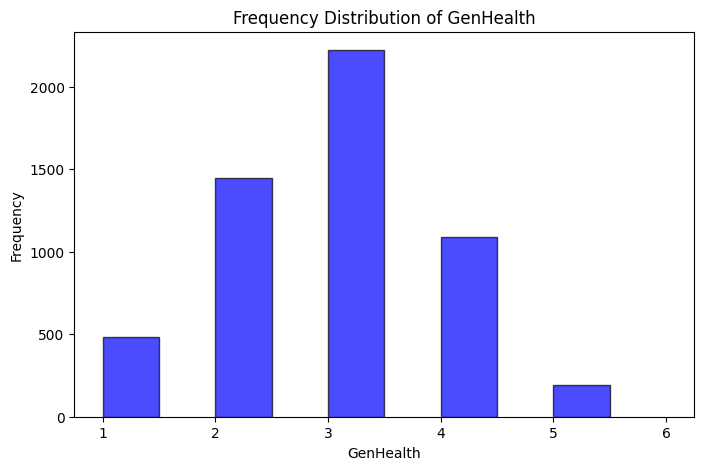

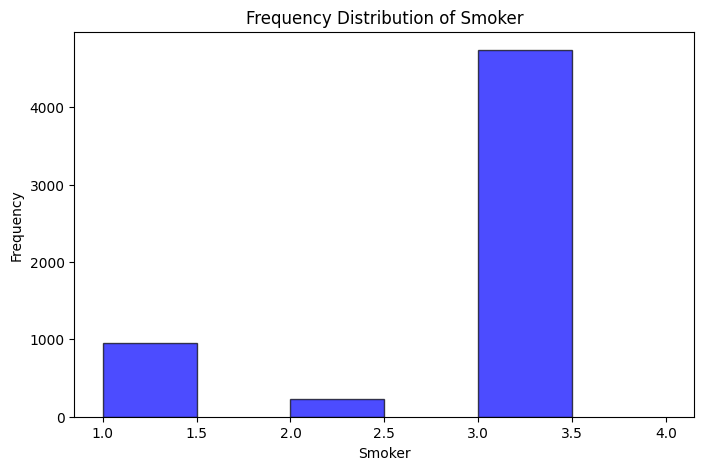

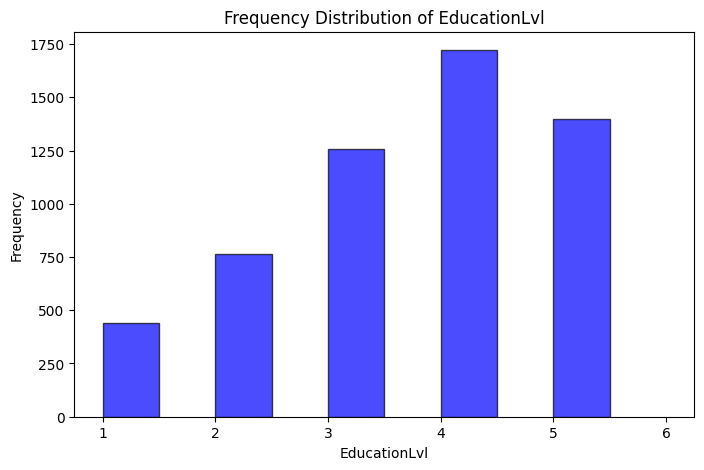

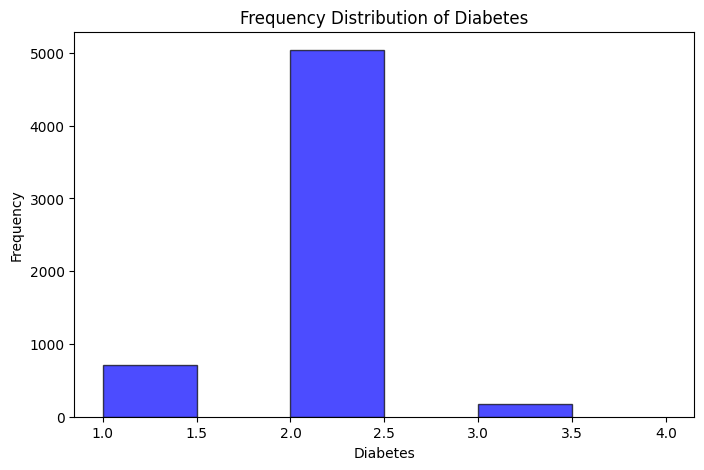

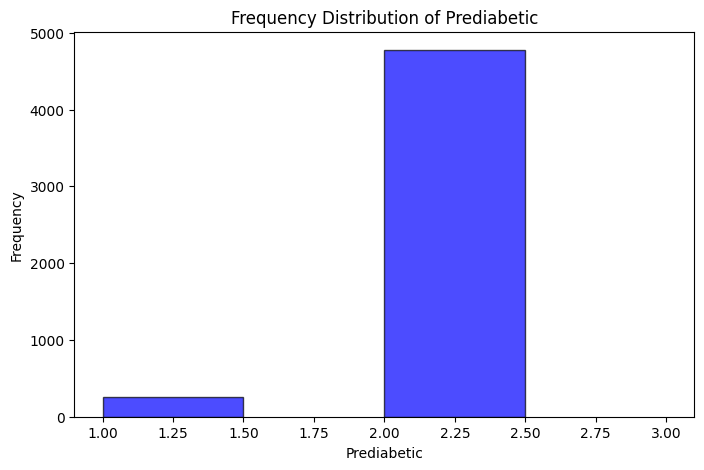

In [192]:
features_seven = ['Gender','Cholesterol','Diet','SaltFreq','Asthma', 'Stroke', 'VigActivity','ModActivity','FeelPoorEating','FeelTired','SleepTroubles','FeelDepressed','AlcConsumpMoreThan4/5MostDays','100Cigs','OvrDietHealth','GenHealth','Smoker','EducationLvl','Diabetes','Prediabetic']
plot_feature_distribution(df, features_seven)

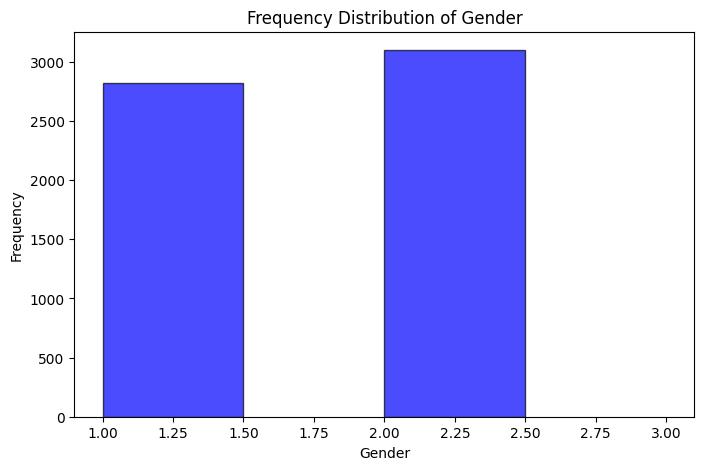

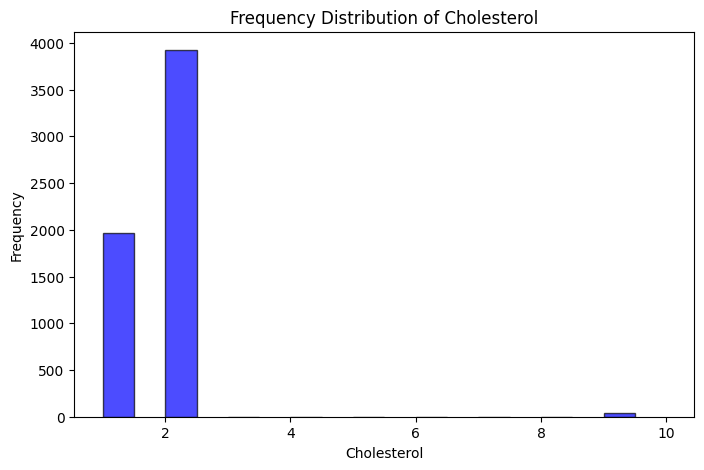

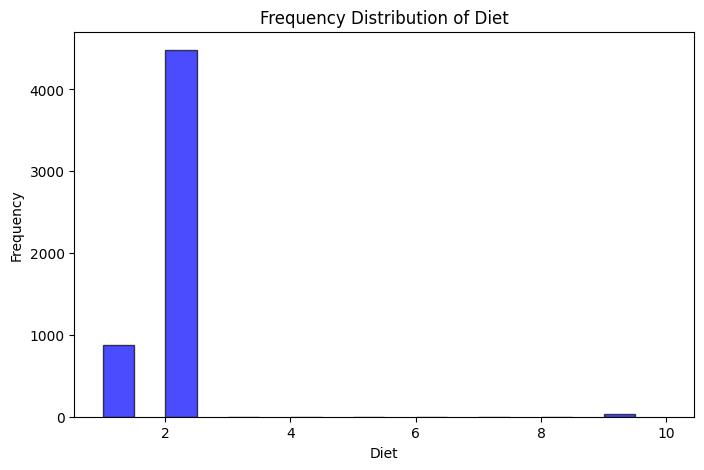

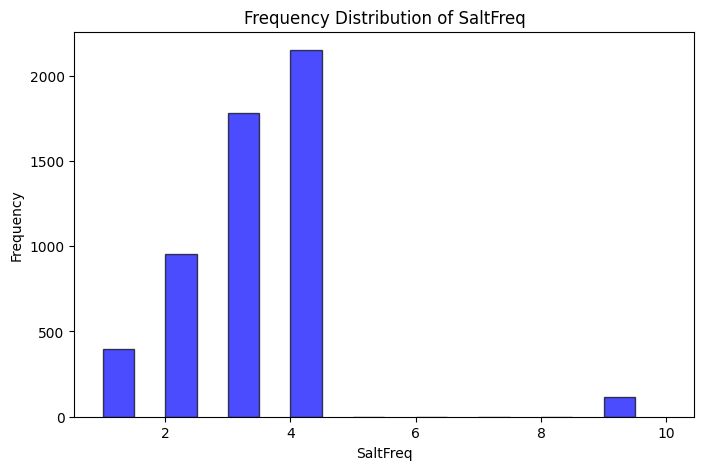

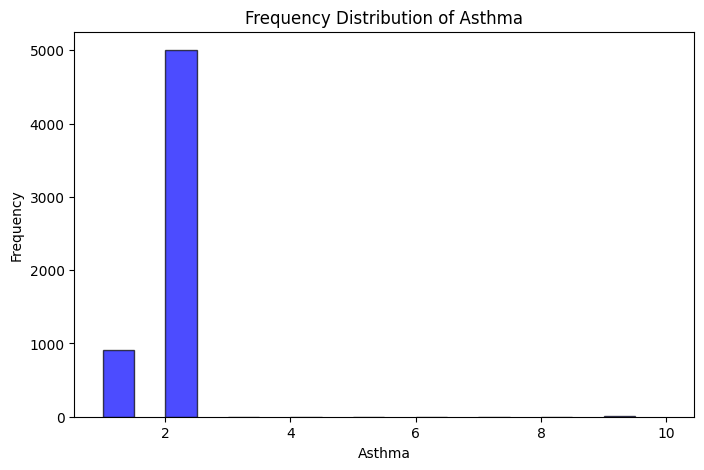

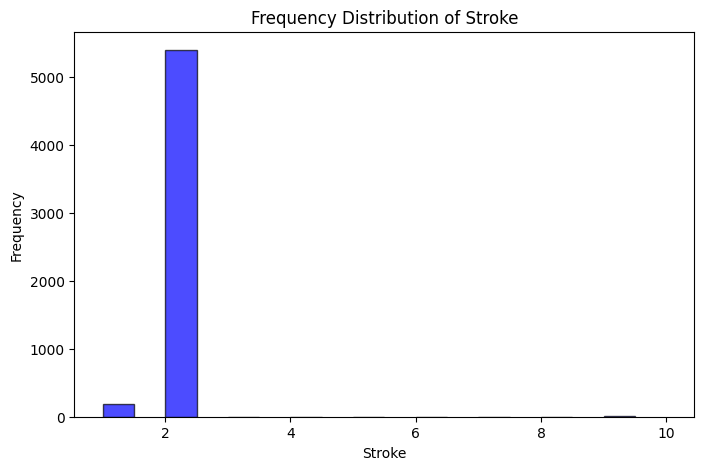

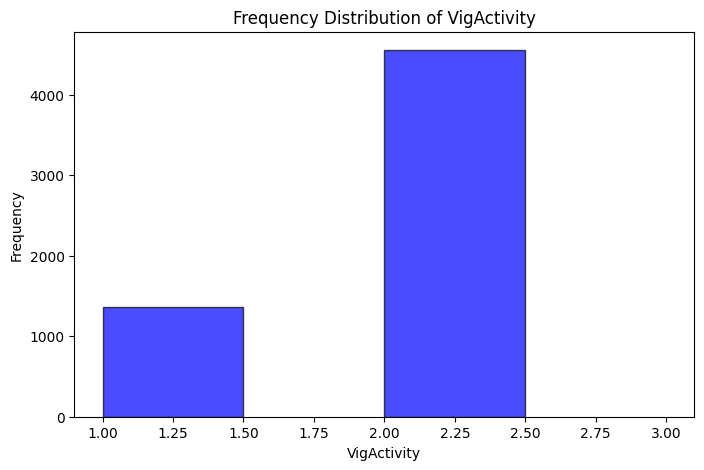

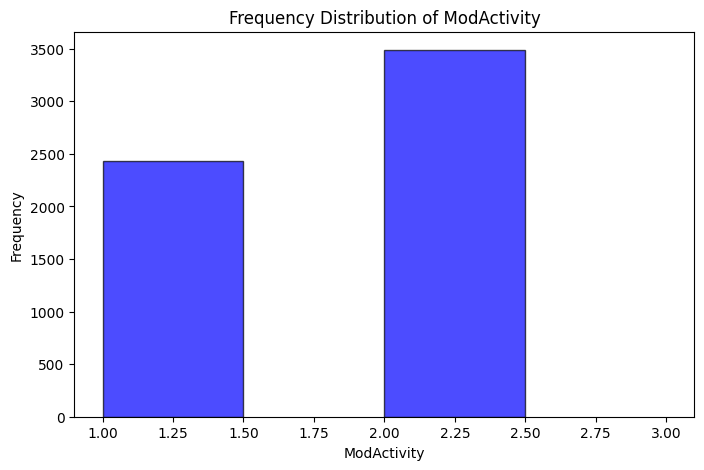

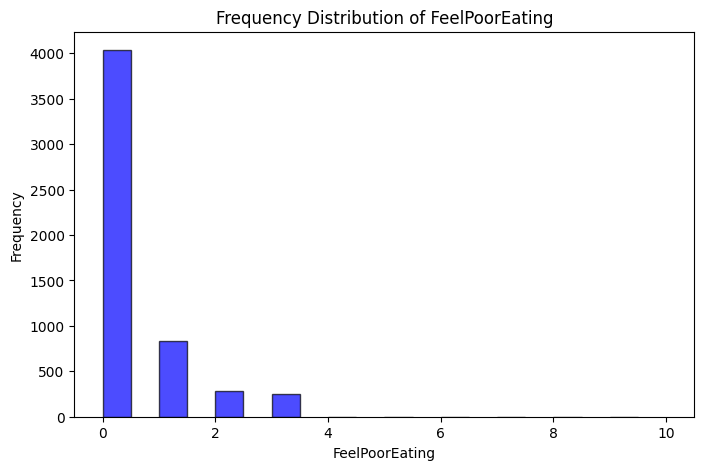

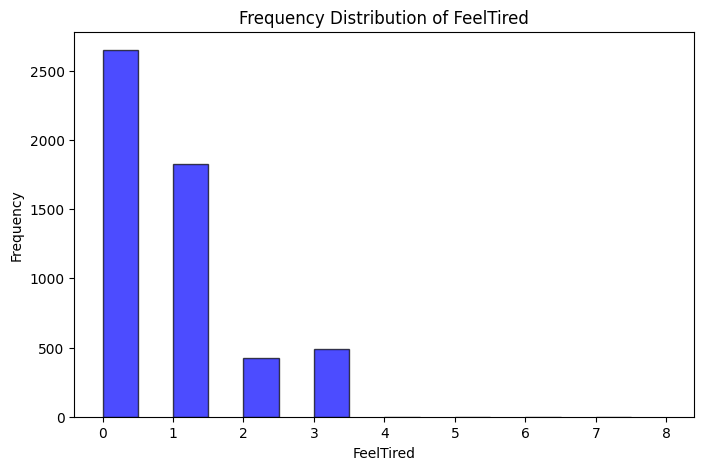

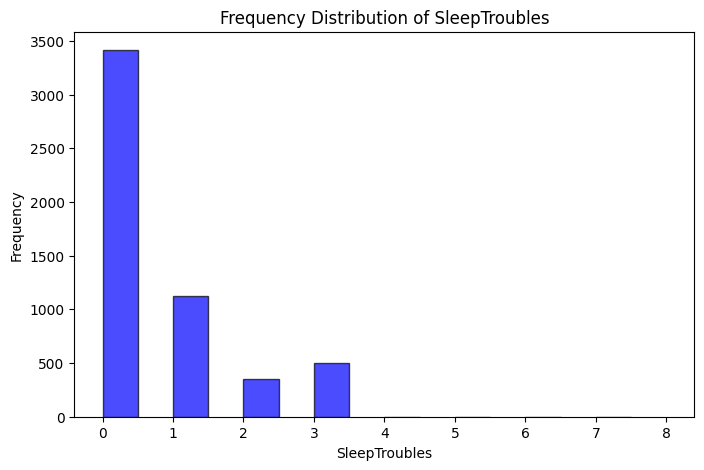

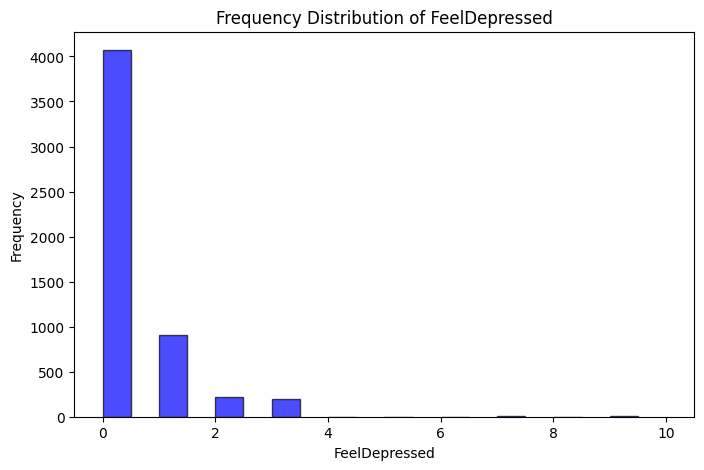

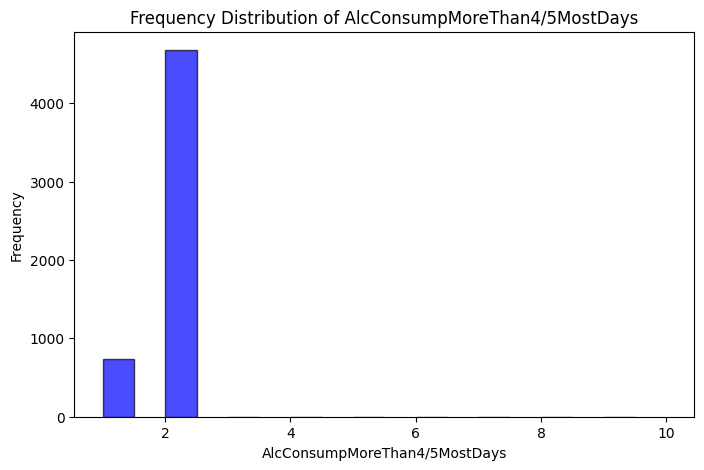

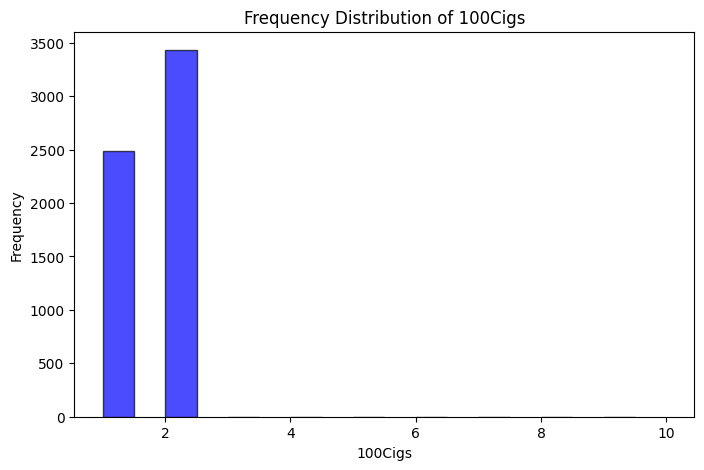

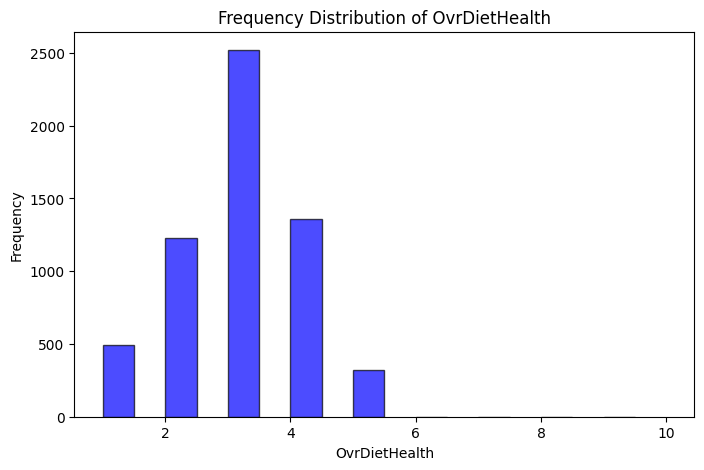

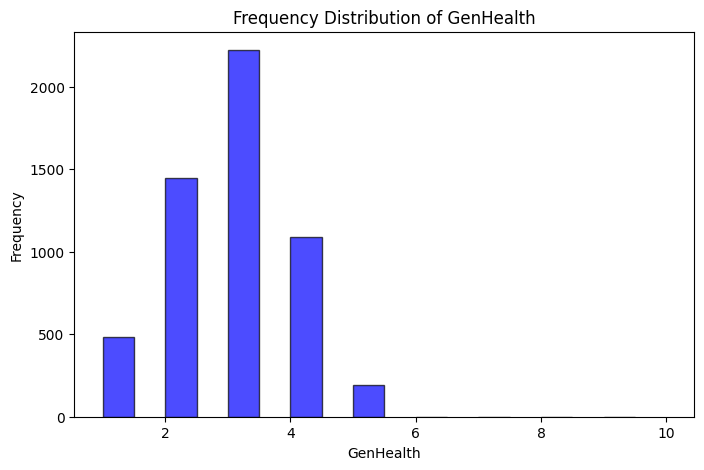

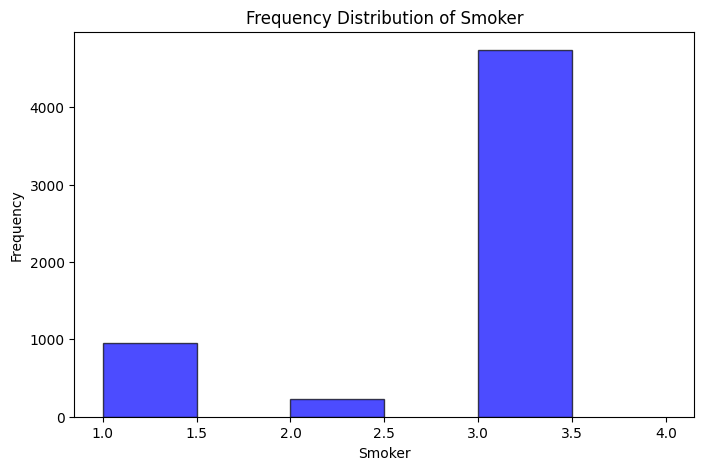

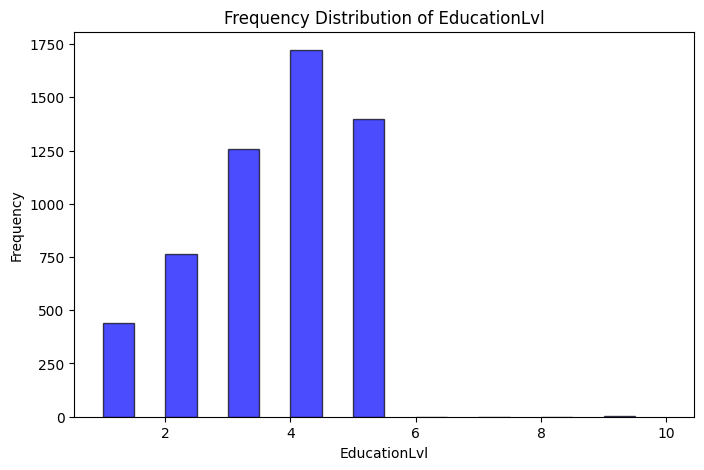

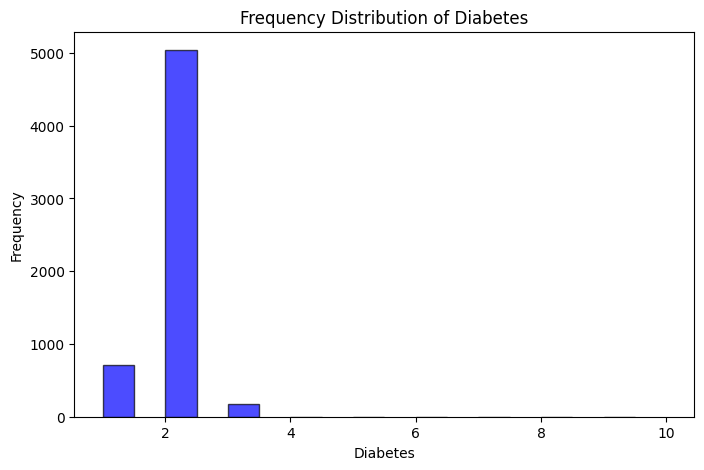

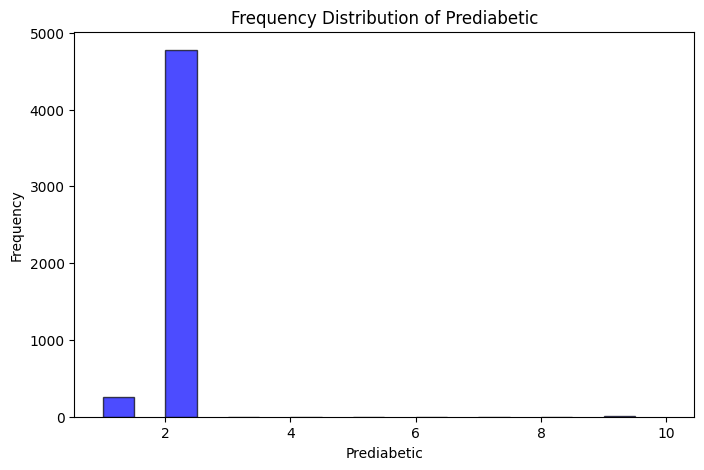

In [193]:
feature_seventy_seven = ['SleepDuringWork']
plot_feature_distribution(df, features_seven, 77)

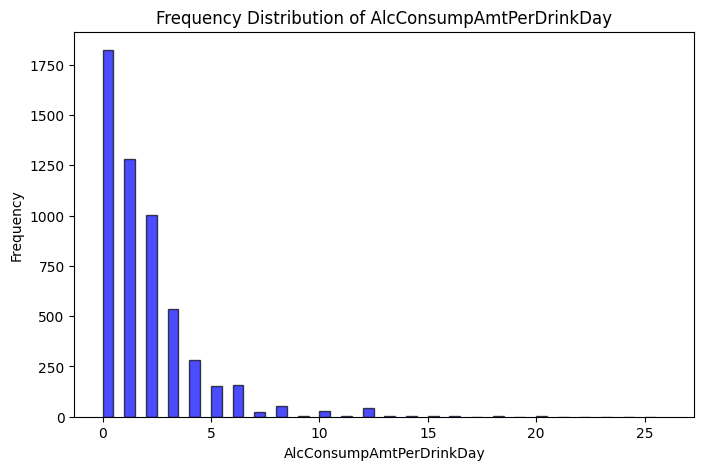

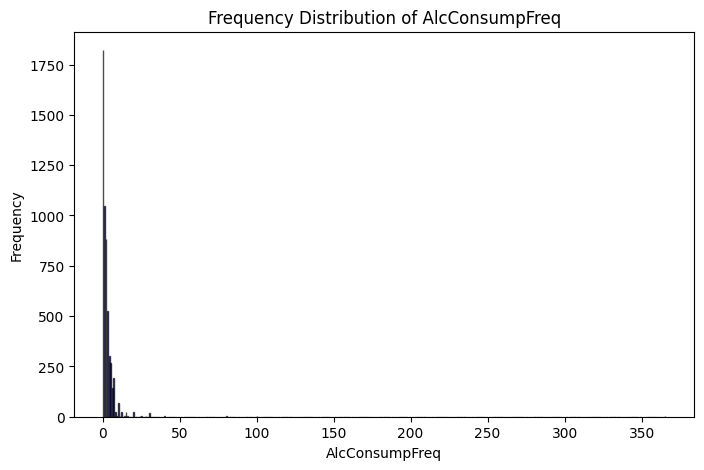

In [194]:
feature_seven_hundred = ['AlcConsumpAmtPerDrinkDay', 'AlcConsumpFreq']
plot_feature_distribution(df, feature_seven_hundred, 777)

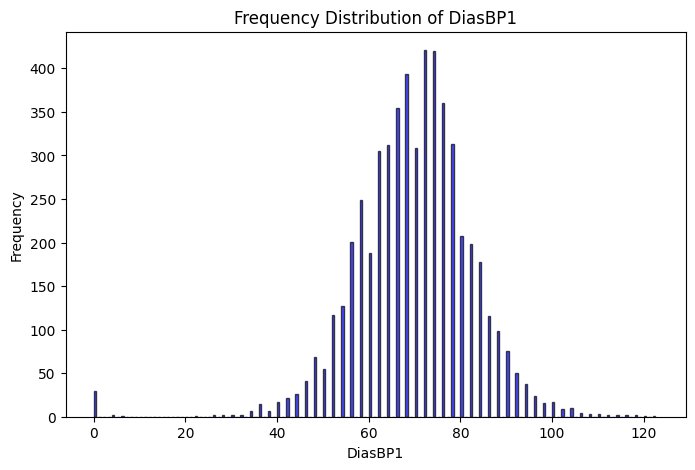

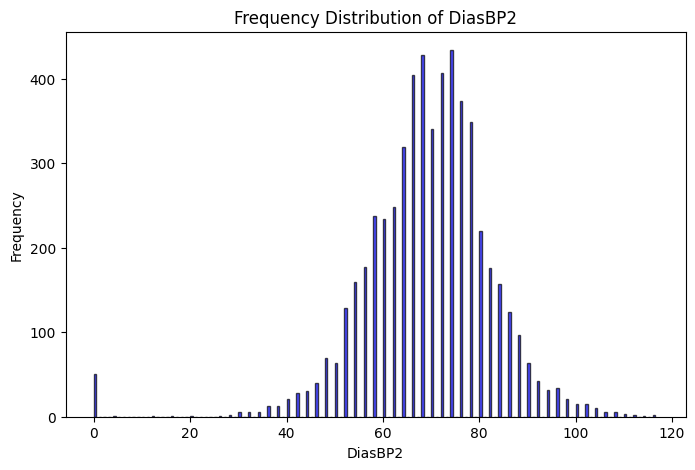

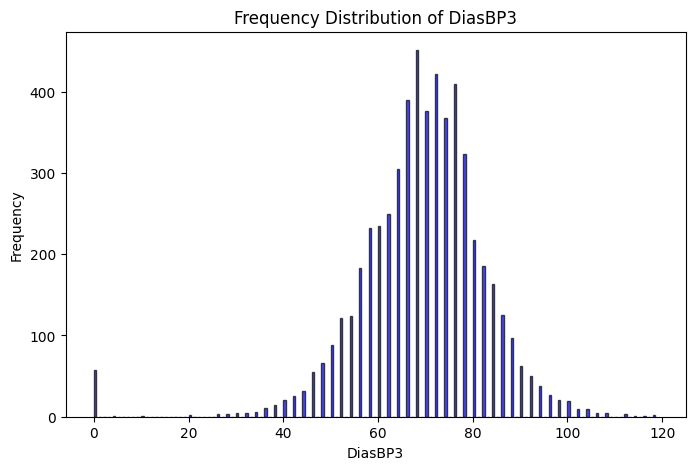

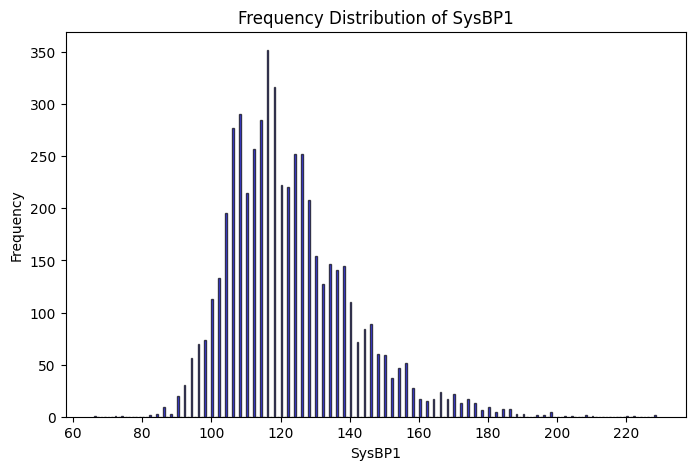

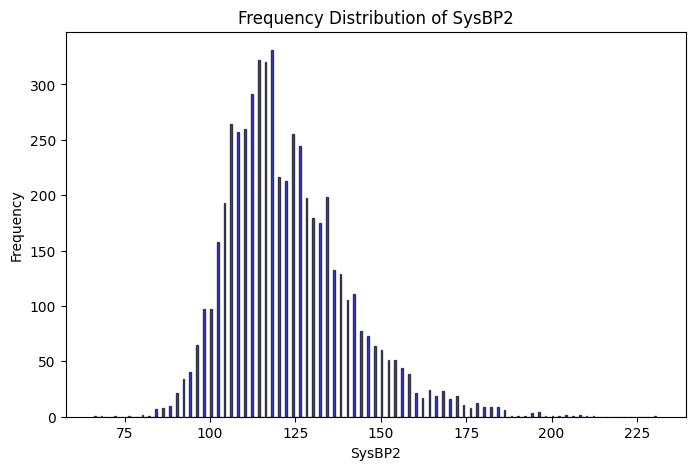

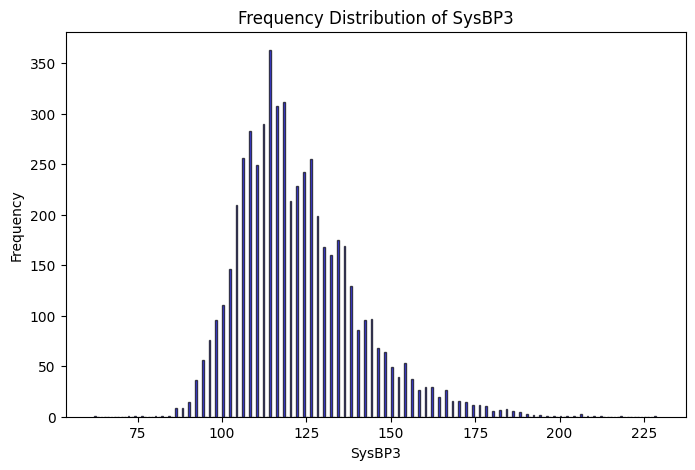

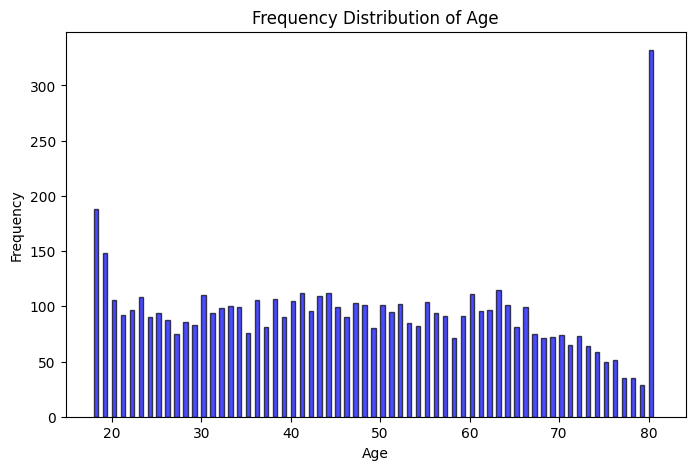

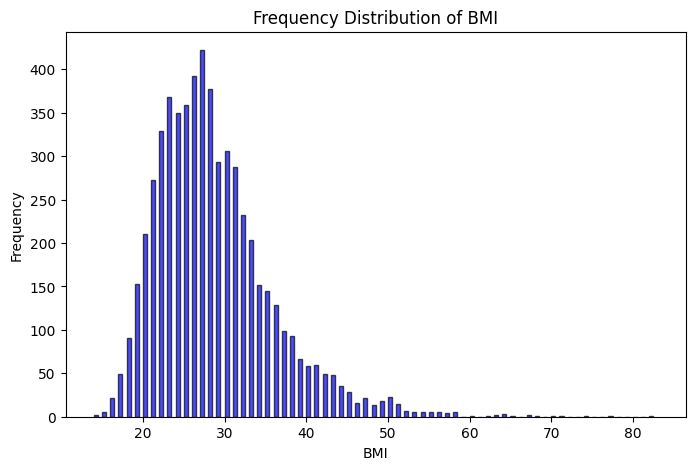

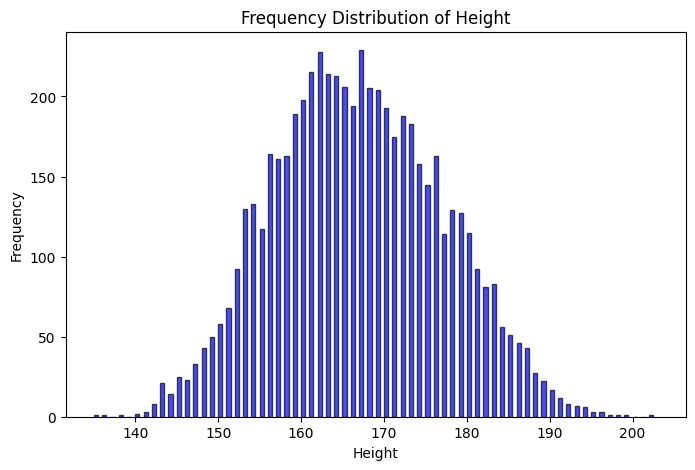

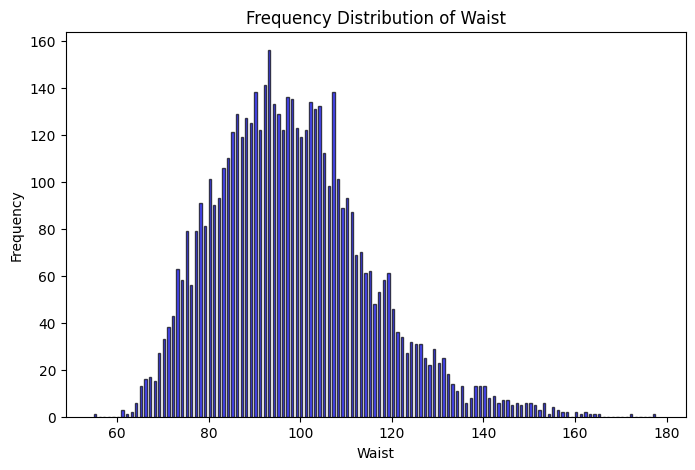

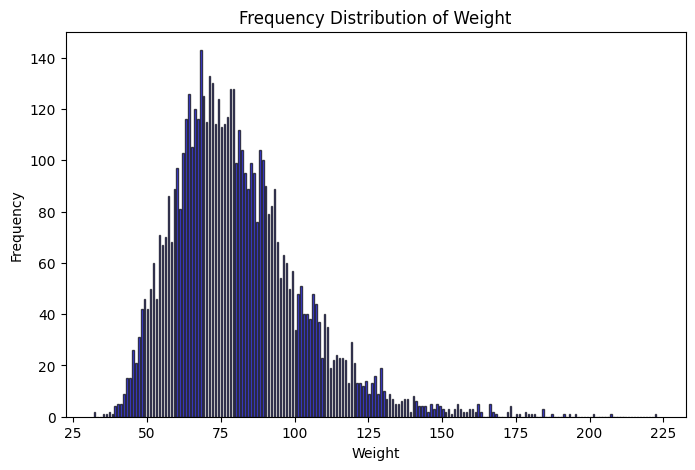

In [195]:
other_features = ['DiasBP1','DiasBP2','DiasBP3','SysBP1','SysBP2','SysBP3','Age', 'BMI','Height','Waist','Weight']
plot_feature_distribution(df, other_features, 1000000)

## Encoding


In [196]:
def encode_yes_no_features(df, feature_names):
    for feature_name in feature_names:
        # Apply the conditions to each specified feature
        df[feature_name] = df[feature_name].apply(lambda x: 1 if x == 1 else (0 if x == 2 else np.nan))

In [197]:
yes_no_features = ['Gender', 'Asthma', 'Stroke', 'VigActivity', 'ModActivity', 'AlcConsumpMoreThan4/5MostDays', '100Cigs', 'Cholesterol', 'Diet', 'Prediabetic']
encode_yes_no_features(df, yes_no_features)

In [198]:
new_column_names = {
    'Gender': 'Male'
}

df.rename(columns=new_column_names, inplace=True)

In [199]:
def minus_one_from_feature_rating(df, feature_names):
    for feature_name in feature_names:
        df[feature_name] = df[feature_name] -1

In [200]:
features_to_minus_one = ['SaltFreq', 'OvrDietHealth', 'GenHealth', 'Smoker', 'EducationLvl', 'Diabetes']
minus_one_from_feature_rating(df, features_to_minus_one)

In [201]:
#Scale features
def scale_features(df, feature_names, threshold=6):
    for feature_name in feature_names:
        # Determine the max value in the feature that is less than the threshold
        max_scale = df[feature_name][df[feature_name] < threshold].max()
        
        # Apply the scaling operation x = x / max_scale if x is less than the threshold
        df[feature_name] = df[feature_name].apply(lambda x: x / max_scale if x < threshold else np.nan)

In [202]:
features_to_scale = ['FeelPoorEating','FeelTired','SleepTroubles','FeelDepressed', 'SaltFreq','OvrDietHealth', 'GenHealth', 'Smoker', 'EducationLvl', 'Diabetes']
scale_features(df, features_to_scale)

In [203]:
features_to_scale = ['AlcConsumpFreq', 'AlcConsumpAmtPerDrinkDay']
scale_features(df, features_to_scale, threshold=777)

features_to_scale = ['SleepDuringWork']
scale_features(df, features_to_scale, threshold=77)

In [204]:
def flip_feature_scaling(df, feature_names):
    for feature_name in feature_names:
        df[feature_name] = 1 - df[feature_name]

In [205]:
features_to_flip = ['OvrDietHealth', 'GenHealth', 'Smoker']
flip_feature_scaling(df, features_to_flip)

In [206]:
df['Diabetes'] = df['Diabetes'].replace({3: 0.5, 2: 0})

In [207]:
def print_unique_values(df, features):

    for feature in features:
        if feature in df.columns:
            unique_values = df[feature].unique()
            print(f"Unique values for '{feature}': {unique_values}")
        else:
            print(f"Feature '{feature}' not found in the df.")

In [208]:
print_unique_values(df, ['OvrDietHealth', 'GenHealth', 'Smoker', 'FeelPoorEating','FeelTired','SleepTroubles','FeelDepressed', 'SaltFreq','OvrDietHealth', 'GenHealth', 'Smoker', 'EducationLvl', 'Diabetes','Gender', 'Asthma', 'Stroke', 'VigActivity', 'ModActivity', 'AlcConsumpMoreThan4/5MostDays', '100Cigs', 'Cholesterol', 'Diet', 'Prediabetic'])

Unique values for 'OvrDietHealth': [0.75 0.5  0.   0.25 1.    nan]
Unique values for 'GenHealth': [0.75 0.25 0.5  0.   1.    nan]
Unique values for 'Smoker': [0.  0.5 1. ]
Unique values for 'FeelPoorEating': [0.         1.         0.33333333        nan 0.66666667]
Unique values for 'FeelTired': [0.         1.         0.33333333        nan 0.66666667]
Unique values for 'SleepTroubles': [0.         1.         0.33333333        nan 0.66666667]
Unique values for 'FeelDepressed': [0.         0.33333333 1.                nan 0.66666667]
Unique values for 'SaltFreq': [1.         0.66666667 0.33333333 0.                nan]
Unique values for 'OvrDietHealth': [0.75 0.5  0.   0.25 1.    nan]
Unique values for 'GenHealth': [0.75 0.25 0.5  0.   1.    nan]
Unique values for 'Smoker': [0.  0.5 1. ]
Unique values for 'EducationLvl': [0.5  0.75 1.   0.25 0.    nan]
Unique values for 'Diabetes': [0.  0.5 1.  nan]
Feature 'Gender' not found in the df.
Unique values for 'Asthma': [ 0.  1. nan]
Unique val